# RNN Modeling of Weight Data

## Setup

In [1]:
from wlp_utils import ml_utils

In [10]:
# %matplotlib inline
# import datetime
# import numpy as np
# import pandas as pd
# import random
# import matplotlib.pyplot as plt
# from sqlalchemy import create_engine
# from sklearn.model_selection import train_test_split
# from ggplot import *

# from wlp_utils import ml_utils

## Data

In [2]:
this = ml_utils.get_model_data_df('2015-09-16', '2017-08-31')
this.head(10)

,Weight,Steps,Calories
Date,,,
2015-09-16,183.5,12452.0,1929.0
2015-09-17,185.4,9778.0,2509.0
2015-09-18,183.1,16295.0,1375.0
2015-09-19,180.7,15560.0,2307.0
2015-09-20,181.0,15370.0,2807.0
2015-09-21,182.9,6968.0,2225.0
2015-09-22,180.8,10589.0,2580.0
2015-09-23,180.9,17142.0,2388.0
2015-09-24,182.4,7602.0,1979.0


In [4]:
data_x, data_y = ml_utils.get_model_data_seq('2015-09-16', '2017-08-31', 10)

In [64]:
data_x[0]

array([[ 0.67    ,  0.3113  ,  0.35725 ],
       [ 0.708   ,  0.24445 ,  0.50225 ],
       [ 0.662   ,  0.407375,  0.21875 ],
       [ 0.614   ,  0.389   ,  0.45175 ],
       [ 0.62    ,  0.38425 ,  0.57675 ],
       [ 0.658   ,  0.1742  ,  0.43125 ],
       [ 0.616   ,  0.264725,  0.52    ],
       [ 0.618   ,  0.42855 ,  0.472   ],
       [ 0.648   ,  0.19005 ,  0.36975 ],
       [ 0.608   ,  0.369475,  0.4185  ]])

In [2]:
def get_data():
    import qstools.preprocess as qsp

    sequence_length = 30
    trainFraction = 0.7
    valFraction = 1-trainFraction
    
    modeldata_df = qsp.load_weight_data()
    modeldata_df.drop(['Date','CaloriesOut','CaloriesBMR','CaloriesActivity','WeightImputed','CaloriesDiff'], axis=1, inplace=True)
    modeldata_df.Weight = (lambda w: (w-150.)/50.)(modeldata_df[['Weight']])
    modeldata_df.Steps = (lambda s: s/40000.)(modeldata_df[['Steps']])
    modeldata_df.Calories = (lambda c: (c-500.)/4000.)(modeldata_df[['Calories']])
    
    modeldata = modeldata_df.as_matrix()
    data_x, data_y = qsp.reshape_sequences_target_sequence(modeldata, sequence_length)    
    
    trainIndexMax = int(data_x.shape[0]*trainFraction)
    valIndexMax = data_x.shape[0]
    
    X_train = data_x[0:trainIndexMax]
    Y_train = data_y[0:trainIndexMax]
    X_test = data_x[(trainIndexMax+1):valIndexMax]
    Y_test = data_y[(trainIndexMax+1):valIndexMax]
    
    return X_train, Y_train, X_test, Y_test

In [2]:
def get_data():
    import qstools.preprocess as qsp

    sequence_length = 30
    train_fraction = 0.8
    val_fraction = 1-train_fraction
    
    modeldata_df = qsp.load_weight_data()
    modeldata_df.drop(['Date','CaloriesOut','CaloriesBMR','CaloriesActivity','WeightImputed','CaloriesDiff'], axis=1, inplace=True)
    modeldata_df.Weight = (lambda w: (w-150.)/50.)(modeldata_df[['Weight']])
    modeldata_df.Steps = (lambda s: s/40000.)(modeldata_df[['Steps']])
    modeldata_df.Calories = (lambda c: (c-500.)/4000.)(modeldata_df[['Calories']])
    
    modeldata = modeldata_df.as_matrix()
    data_x, data_y = qsp.reshape_sequences_target_sequence(modeldata, sequence_length)
    
    X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size=val_fraction, random_state=42)
    
    return X_train, Y_train, X_test, Y_test

## Model

In [3]:
# NOTE: There is no easy way to keep a single source of truth for these parameters
# It requires cutting and pasting to keep in sync with get_trained_model function

lstm_size=[50, 100, 200]
dropout_rate=[0, .1, .2, .3]
batch_size=[10, 20, 40]
number_of_epochs=[10, 20, 40, 80]

sequence_length=30
loss_function='mean_absolute_error'
optimization_method='adam'

In [4]:
len(lstm_size)*len(dropout_rate)*len(batch_size)*len(number_of_epochs)

144

In [5]:
def get_trained_model(X_train, Y_train, X_test, Y_test):
    from keras.layers import Input
    from keras.layers import Dense
    from keras.layers import Dropout
    from keras.layers import LSTM
    from keras.layers import TimeDistributed
    from keras.models import Model
    
    sequence_length=30
    loss_function='mean_absolute_error'
    optimization_method='adam'
    
    layer_input = Input(shape=(sequence_length, 3))
    layer_lstm = LSTM({{choice([50, 100, 200])}}, return_sequences=True)(layer_input)
    layer_dropout = Dropout({{choice([0, .1, .2, .3])}})(layer_lstm)
    layer_output = TimeDistributed(Dense(1))(layer_dropout)
    
    model = Model(input=[layer_input], output=[layer_output])
    model.compile(loss=loss_function, optimizer=optimization_method)    
    
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
              batch_size={{choice([10, 20, 40])}}, 
              nb_epoch={{choice([10, 20, 40, 80])}}, verbose=2)
    loss = model.evaluate(X_test, Y_test, verbose=0)
    
    print('Test loss:', loss)
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

## Grid search

In [6]:
trials_results = hyperopt.Trials()

best_run, best_model = optim.minimize(notebook_name='predicting_weight', 
                                      verbose=False, 
                                      model=get_trained_model, 
                                      data=get_data, 
                                      algo=hyperopt.tpe.suggest, 
                                      max_evals=144, trials=trials_results)

Train on 308 samples, validate on 78 samples
Epoch 1/40
0s - loss: 0.2337 - val_loss: 0.1154
Epoch 2/40
0s - loss: 0.1056 - val_loss: 0.0623
Epoch 3/40
0s - loss: 0.0805 - val_loss: 0.0501
Epoch 4/40
0s - loss: 0.0696 - val_loss: 0.0463
Epoch 5/40
0s - loss: 0.0621 - val_loss: 0.0425
Epoch 6/40
0s - loss: 0.0569 - val_loss: 0.0400
Epoch 7/40
0s - loss: 0.0529 - val_loss: 0.0379
Epoch 8/40
0s - loss: 0.0504 - val_loss: 0.0362
Epoch 9/40
0s - loss: 0.0479 - val_loss: 0.0353
Epoch 10/40
0s - loss: 0.0451 - val_loss: 0.0336
Epoch 11/40
0s - loss: 0.0435 - val_loss: 0.0327
Epoch 12/40
0s - loss: 0.0423 - val_loss: 0.0335
Epoch 13/40
0s - loss: 0.0405 - val_loss: 0.0315
Epoch 14/40
0s - loss: 0.0390 - val_loss: 0.0303
Epoch 15/40
0s - loss: 0.0380 - val_loss: 0.0293
Epoch 16/40
0s - loss: 0.0372 - val_loss: 0.0294
Epoch 17/40
0s - loss: 0.0364 - val_loss: 0.0281
Epoch 18/40
0s - loss: 0.0355 - val_loss: 0.0275
Epoch 19/40
0s - loss: 0.0344 - val_loss: 0.0270
Epoch 20/40
0s - loss: 0.0342 - v

In [7]:
trials_results.best_trial

{'book_time': datetime.datetime(2016, 12, 24, 17, 55, 36, 960000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'Dropout': [101],
   'LSTM': [101],
   'batch_size': [101],
   'nb_epoch': [101]},
  'tid': 101,
  'vals': {'Dropout': 0, 'LSTM': 2, 'batch_size': 0, 'nb_epoch': 3},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2016, 12, 24, 17, 56, 42, 114000),
 'result': {'loss': 0.01414740952448203,
  'model': <keras.engine.training.Model at 0x2a5c544d0>,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 101,
 'version': 0}

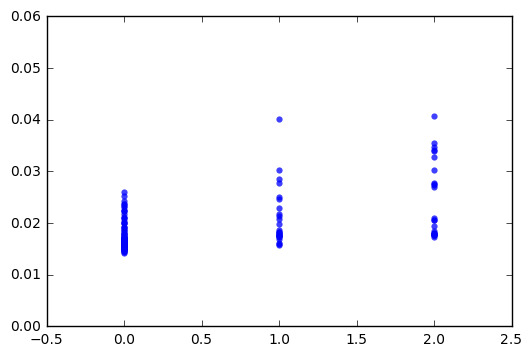

In [8]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['batch_size'] for t in trials_results.trials]
ys = [t['result']['loss'] for t in trials_results.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)

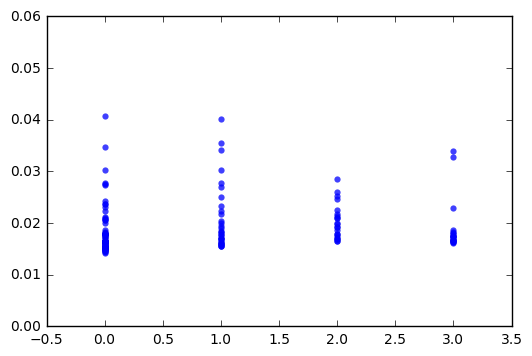

In [9]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['Dropout'] for t in trials_results.trials]
ys = [t['result']['loss'] for t in trials_results.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)

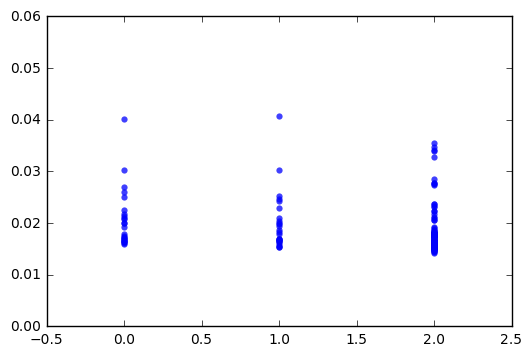

In [10]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['LSTM'] for t in trials_results.trials]
ys = [t['result']['loss'] for t in trials_results.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)

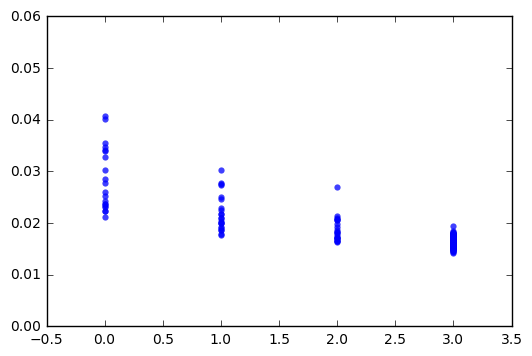

In [11]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['nb_epoch'] for t in trials_results.trials]
ys = [t['result']['loss'] for t in trials_results.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)

In [12]:
print lstm_size[best_run['LSTM']]
print dropout_rate[best_run['Dropout']]
print batch_size[best_run['batch_size']]
print number_of_epochs[best_run['nb_epoch']]

200
0
10
80


## Model evaluation

In [13]:
def weightTransform(w):
    return (w - 150.)/50.
def stepsTransform(s):
    return s/40000.
def caloriesTransform(c):
    return (c-500.)/4000.

def weightInverseTransform(w):
    return w*50+150.
def stepsInverseTransform(s):
    return s*40000.
def caloriesInverseTransform(c):
    return c*4000. + 500.

In [14]:
X_train, Y_train, X_val, Y_val = get_data()

In [15]:
index = random.sample(range(0, len(X_val)), 1)[0]
print index

x_in = np.array([X_val[index]])
pred = best_model.predict(x_in)

print weightInverseTransform(Y_val[index][-1][0])
print weightInverseTransform(pred[0][-1][0])

68
170.2
169.992630184


In [16]:
errors = np.array([0 for i in range(0,len(X_val[0]))])
for i in range(0, len(X_val)):
    x_in = np.array([X_val[i]])
    pred = best_model.predict(x_in)[0]
    true = Y_val[i]
    errors = errors + np.abs(true-pred).reshape(len(X_val[0]))
errors = 50*errors/len(X_val)

In [17]:
errors.mean()

0.74169299038658776

In [18]:
errors[-1]

0.80388240080613305

In [19]:
errors[-5:].mean()

0.69922808032158024

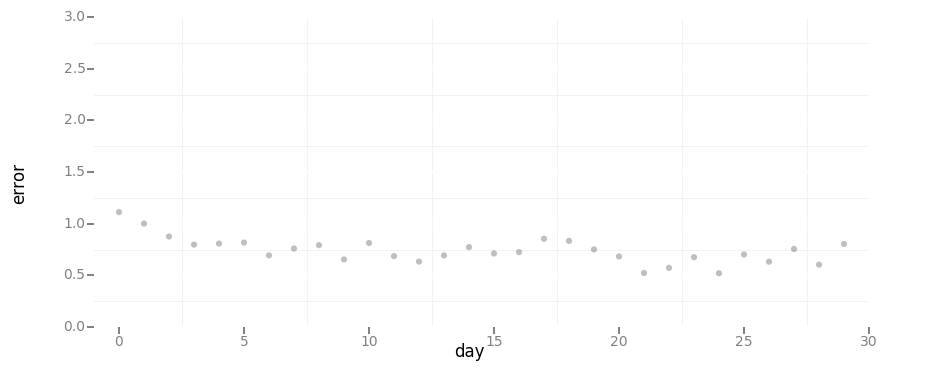

In [20]:
errors_df = pd.DataFrame({'day':range(0,len(X_val[0])), 'error':errors})

p = ggplot(aes(x='day', y='error'), data=errors_df) +\
geom_point(color='black', alpha=0.25)  +\
scale_x_continuous(limits=(-1, 30)) +\
scale_y_continuous(limits=(0, 3)) +\
theme_bw()

p.save('test.png', width=10, height=4)

In [21]:
sequence_length = 30

modeldata_df = qsp.load_weight_data()
modeldata_df.drop(['Date','CaloriesOut','CaloriesBMR','CaloriesActivity','WeightImputed','CaloriesDiff'], axis=1, inplace=True)
modeldata_df.Weight = (lambda w: (w-150.)/50.)(modeldata_df[['Weight']])
modeldata_df.Steps = (lambda s: s/40000.)(modeldata_df[['Steps']])
modeldata_df.Calories = (lambda c: (c-500.)/4000.)(modeldata_df[['Calories']])

modeldata = modeldata_df.as_matrix()
modeldata_predicted = modeldata.copy()

In [22]:
maxsteps = len(modeldata_predicted) - sequence_length - 1
offset = 0
for i in range(offset, maxsteps):
#    print i
    data_t0 = modeldata_predicted[i:(sequence_length+i)]
    pred = best_model.predict(np.array([data_t0]))[0]
#    print pred[-1][0]
    modeldata_predicted[sequence_length+i+1,0] = pred[-1][0]

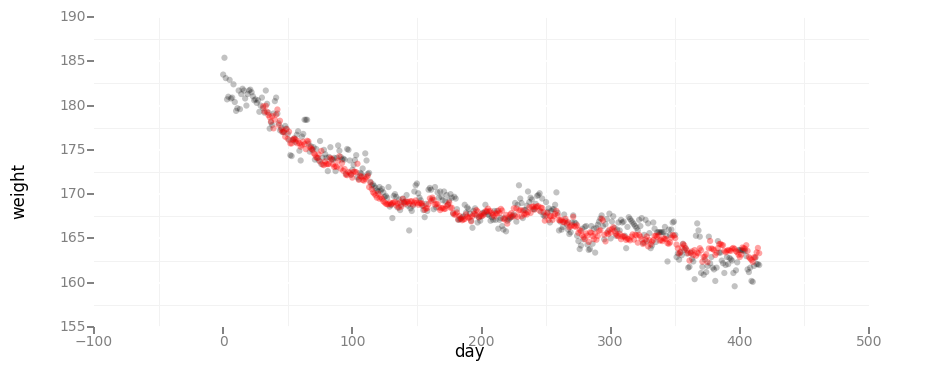

In [23]:
daymax = offset + 416
alphaval = 0.3

weight_true = weightInverseTransform(modeldata[:,0])
weight_true_df = pd.DataFrame({'day':range(0,len(weight_true)), 'weight':weight_true})
weight_true_df = weight_true_df[weight_true_df.day<=daymax]

weight_pred = weightInverseTransform(modeldata_predicted[:,0])
weight_pred_df = pd.DataFrame({'day':range(0,len(weight_true)), 'weight':weight_pred})
weight_pred_df = weight_pred_df[weight_pred_df.day>(offset+sequence_length)]
# weight_pred_df = weight_pred_df[weight_pred_df.day<=daymax]

p = ggplot(aes(x='day', y='weight'), data=weight_true_df) +\
geom_point(color='black', alpha=alphaval*.8)  +\
geom_point(data=weight_pred_df, color='red', alpha=alphaval*1.2) +\
theme_bw()

p.save('test.png', width=10, height=4)

In [49]:
cutoff = 416
param_steps = stepsTransform(10000)
param_cals = caloriesTransform(1000)

modeldata_predicted = modeldata.copy()
modeldata_predicted = modeldata_predicted[cutoff-sequence_length:cutoff]
modeldata_predicted[sequence_length-1,1] = param_steps
modeldata_predicted[sequence_length-1,2] = param_cals

maxsteps = 300
for i in range(0, maxsteps):
    data_t0 = modeldata_predicted[i:(sequence_length+i)]
    pred = best_model.predict(np.array([data_t0]))[0]
    modeldata_predicted = np.append(modeldata_predicted, np.array([[pred[-1][0], param_steps, param_cals]]), axis=0)

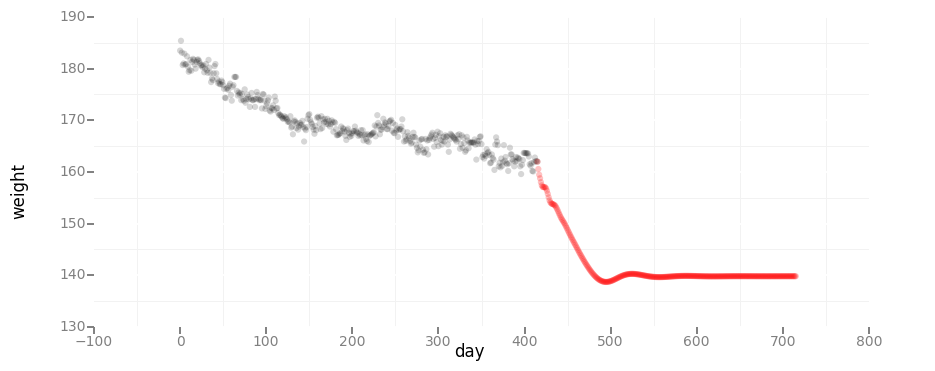

In [50]:
alphaval = 0.2

weight_true = weightInverseTransform(modeldata[:,0])
weight_true_df = pd.DataFrame({'day':range(0,len(weight_true)), 'weight':weight_true})

weight_pred = weightInverseTransform(modeldata_predicted[:,0])
weight_pred_df = pd.DataFrame({'day':[x + cutoff-sequence_length for x in range(0,len(weight_pred))], 'weight':weight_pred})
weight_pred_df = weight_pred_df[weight_pred_df.day>(cutoff-2)]

p = ggplot(aes(x='day', y='weight'), data=weight_true_df) +\
geom_point(color='black', alpha=alphaval*.8)  +\
geom_point(data=weight_pred_df, color='red', alpha=alphaval*1.2) +\
theme_bw()

p.save('test.png', width=10, height=4)